# Problem 1. Neural Networks: MNIST image classification


In this problem, you will implement a simple convolutional neural network to classify grayscale images of handwritten digits ($0-9$) from the MNIST dataset. The dataset contains $60,000$ training images and $10,000$ testing images of handwritten digits, $0-9$. Each image is $28\times 28$ pixels in size with only a single channel. It also includes labels for each example, a number indicating the actual digit ($0-9$) handwritten in that image.

The following shows some example images from the [MNIST](https://commons.wikimedia.org/wiki/File:MnistExamples.png) dataset:

![Figure 1](Images/Untitled.png)



The data for this problem can be found in the data folder as `images_train.csv`, `images_test.csv`, `labels_train.csv` and `labels_test.csv`.

The code for this assignment can be found within p1 nn.py within the src folder.

The starter code splits the set of $60,000$ training images and labels into a sets of $59,600$ examples
as the training set and $400$ examples for dev set.

To start, you will implement a simple convolutional neural network and cross entropy loss, and train it with the provided data set.

The architecture is as follows:

> (a) The first layer is a convolutional layer with $2$ output channels with a convolution size of $4$ by $4$.

> (b) The second layer is a max pooling layer of stride and width $5$ by $5$.

> (c) The third layer is a ReLU activation layer.

> (d) After the four layer, the data is flattened into a single dimension.

> (e) The fith layer is a single linear layer with output size $10$ (the number of classes).

> (f) The sixth layer is a softmax layer that computes the probabilities for each class.

> (g) Finally, we use a cross entropy loss as our loss function.

We have provided all of the forward functions for these different layers so there is an unambigious definition of them in the code. Your job in this assignment will be to implement functions that compute the gradients for these layers. However, here is some additional text that might be
helpful in understanding the forward functions.

We have discussed convolutional layers on the exam, but as a review, the following equation defines what we mean by a $2d$ convolution:

\begin{align*}
output[out\_channel,x,y] 
& = convolution\_bias[out\_channel] + \\
& \sum_{di, dj, in\_channel} input[in\_channel, x + di, y + dy] \times convolution\_weights[out\_channel, in\_channel, di, dj]
\end{align*}
di and dj iterate through the convolution width and height respectively.

The output of a convolution is of size (# output channels, input width - convolution width $ + 1$, output 
height - convolution height $ + 1$). Note that the dimension of the output is smaller due to padding issues.

Max pooling layers simply take the maximum element over a grid. It's defined by the following function

\begin{align*}
output[out\_channel, x, y] = \max_{di,dj} input[in\_channel, x \times pool\_width + di, y \times pool\_height + dy]
\end{align*}

The ReLU (rectified linear unit) is our activation function. The ReLU is simply $\max(0, x)$ where $x$ is the input.
We use cross entropy loss as our loss function. Recall that for a single example $(x, y)$, the cross entropy loss is:

\begin{align*}
CE(y,\hat{y}) = -\sum_{k=1}^K y_k\log \hat{y}_k,
\end{align*}

where $\hat{y}_k\in\mathbb{R}^k$ is the vector of softmax outputs from the model for the training example $x$, and
$y\in\mathbb{R}^k$ is theground-truth vector for the training examplex such that $y = [0,\ldots,0,1,0\ldots,0]^T$ contains a single $1$ at the position of the correct class (also called a “one-hot” representation).

We are also doing mini-batch gradient descent with a batch size of $16$. Normally we would iterater over the data multiple times with multiple epochs, but for this assignment we only do $400$ batches to save time.

## (a) [20 points]
Implement the following functions within `p1_nn.py`. We recommend that you start at the top of the list and work your way down:


> i. backward softmax 

> ii. backward relu

> iii. backward log loss 

> iv. backward linear

> v. backward convolution 

>vi. backward max pool


### Answer:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def read_data(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')

    x = np.reshape(x, (x.shape[0], 1, 28, 28))

    return x, y

In [3]:
train_data, train_labels = read_data('data/mnist/images_train.csv', 'data/mnist/labels_train.csv')

In [4]:
MAX_POOL_SIZE = 5
CONVOLUTION_SIZE = 4
CONVOLUTION_FILTERS = 2

In [5]:
def forward_cross_entropy_loss(probabilities, labels):
    """
    Compute the output from a cross entropy loss layer given the probabilities and labels.

    probabilities is of the shape (# classes)
    labels is of the shape (# classes)

    The output should be a scalar

    Returns:
        The result of the log loss layer
    """

    result = 0

    for i, label in enumerate(labels):
        if label == 1:
            result += -np.log(probabilities[i])

    return result

def backward_cross_entropy_loss(probabilities, labels):
    """
    Compute the gradient of the cross entropy loss with respect to the probabilities.

    probabilities is of the shape (# classes)
    labels is of the shape (# classes)

    The output should be the gradient with respect to the probabilities.

    Returns:
        The gradient of the loss with respect to the probabilities.
    """

    # *** START CODE HERE ***
    
    return -labels/probabilities

    # *** END CODE HERE ***

In [6]:
def forward_softmax(x):
    """
    Compute softmax function for a single example.
    The shape of the input is of size # num classes.

    Important Note: You must be careful to avoid overflow for this function. Functions
    like softmax have a tendency to overflow when very large numbers like e^10000 are computed.
    You will know that your function is overflow resistent when it can handle input like:
    np.array([[10000, 10010, 10]]) without issues.

    Args:
        x: A 1d numpy float array of shape number_of_classes

    Returns:
        A 1d numpy float array containing the softmax results of shape  number_of_classes
    """
    x = x - np.max(x,axis=0)
    exp = np.exp(x)
    s = exp / np.sum(exp,axis=0)
    return s

def backward_softmax(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x.

    grad_outputs is the gradient of the loss with respect to the outputs of the softmax.

    Args:
        x: A 1d numpy float array of shape number_of_classes
        grad_outputs: A 1d numpy flaot array of shape number_of_classes (the grad of the loss w.r.t. probabilities)

    Returns:
        A 1d numpy float array of the same shape as x with the derivative of the loss with respect to x
    """
    
    # *** START CODE HERE ***
    z = forward_softmax(x)
    d  = z.shape[0]
    temp = np.zeros((d,d))
    np.fill_diagonal(temp, z)
    dx = -z.reshape(-1,1) @ z.reshape(1,-1) + temp
    dx = dx @ grad_outputs.reshape(-1,1)
    
    return dx.reshape(-1,)    
    
    # *** END CODE HERE ***

In [7]:
def forward_relu(x):
    """
    Compute the relu function for the input x.

    Args:
        x: A numpy float array

    Returns:
        A numpy float array containing the relu results
    """

    x[x<=0] = 0

    return x

def backward_relu(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x

    Args:
        x: A numpy array of arbitrary shape containing the input.
        grad_outputs: A numpy array of the same shape of x containing the gradient of the loss with respect
            to the output of relu

    Returns:
        A numpy array of the same shape as x containing the gradients with respect to x.
    """
    # *** START CODE HERE ***
    
    return grad_outputs * (x>0)
    
    # *** END CODE HERE ***

In [8]:
def get_initial_params():
    """
    Compute the initial parameters for the neural network.

    This function should return a dictionary mapping parameter names to numpy arrays containing
    the initial values for those parameters.

    There should be four parameters for this model:
    W1 is the weight matrix for the convolutional layer
    b1 is the bias vector for the convolutional layer
    W2 is the weight matrix for the output layers
    b2 is the bias vector for the output layer

    Weight matrices should be initialized with values drawn from a random normal distribution.
    The mean of that distribution should be 0.
    The variance of that distribution should be 1/sqrt(n) where n is the number of neurons that 
    feed into an output for that layer.

    Bias vectors should be initialized with zero.
    
    
    Returns:
        A dict mapping parameter names to numpy arrays
    """

    size_after_convolution = 28 - CONVOLUTION_SIZE + 1
    size_after_max_pooling = size_after_convolution // MAX_POOL_SIZE

    num_hidden = size_after_max_pooling * size_after_max_pooling * CONVOLUTION_FILTERS

    return {
        'W1': np.random.normal(size = (CONVOLUTION_FILTERS, 1, CONVOLUTION_SIZE, CONVOLUTION_SIZE), scale=1/ math.sqrt(CONVOLUTION_SIZE * CONVOLUTION_SIZE)),
        'b1': np.zeros(CONVOLUTION_FILTERS),
        'W2': np.random.normal(size = (num_hidden, 10), scale = 1/ math.sqrt(num_hidden)),
        'b2': np.zeros(10)
    }




In [9]:
def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """

    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros((conv_channels, input_width - conv_width + 1, input_height - conv_height + 1))

    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = np.sum(
                    np.multiply(data[:, x:(x + conv_width), y:(y + conv_height)], conv_W[output_channel, :, :, :])) + conv_b[output_channel]


    return output

def backward_convolution(conv_W, conv_b, data, output_grad):
    """
    Compute the gradient of the loss with respect to the parameters of the convolution.

    See forward_convolution for the sizes of the arguments.
    output_grad is the gradient of the loss with respect to the output of the convolution.

    Returns:
        A tuple containing 3 gradients.
        The first element is the gradient of the loss with respect to the convolution weights
        The second element is the gradient of the loss with respect to the convolution bias
        The third element is the gradient of the loss with respect to the input data
    """

    # *** START CODE HERE ***
    
    conv_channels, _, conv_width, conv_height = conv_W.shape
    input_channels, input_width, input_height = data.shape
    
    dw = np.zeros(conv_W.shape)
    dd = np.zeros(data.shape)
    db = np.zeros(conv_channels)
    
    #for output_channel in range(conv_channels):
    #    for x in range(input_width - conv_width + 1):
    #        for y in range(input_height - conv_height + 1):
                
    #            dw[output_channel] += data[:, x:(x + conv_width), y:(y + conv_height)] * output_grad[output_channel,x,y]
    #            dd[:, x:(x + conv_width), y:(y + conv_height)] += conv_W[output_channel] * output_grad[output_channel,x,y]
    
    
    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            
            temp1 = data[:, x:(x + conv_width), y:(y + conv_height)].reshape(1, -1)
            dw += (temp1 * output_grad[:,x,y].reshape(-1,1)).reshape(dw.shape)
            
            temp2 = conv_W.reshape(conv_channels,-1) * (output_grad[:,x,y].reshape(-1,1))
            temp2 = temp2.sum(axis = 0).reshape(input_channels, conv_width, conv_height)
            dd[:, x:(x + conv_width), y:(y + conv_height)] += temp2
            
    
    db = output_grad.sum(axis = (1,2))
    
    return dw, db, dd

    # *** END CODE HERE ***

In [10]:
def forward_max_pool(data, pool_width, pool_height):
    """
    Compute the output from a max pooling layer given the data and pool dimensions.

    The stride length should be equal to the pool size

    data is of the shape (# channels, width, height)

    The output should be the result of the max pooling layer and should be of size:
        (# channels, width // pool_width, height // pool_height)

    Returns:
        The result of the max pooling layer
    """


    input_channels, input_width, input_height = data.shape

    output = np.zeros((input_channels, input_width // pool_width, input_height // pool_height))

    for x in range(0, input_width, pool_width):
        for y in range(0, input_height, pool_height):

            output[:, x // pool_width, y // pool_height] = np.amax(data[:, x:(x + pool_width), y:(y + pool_height)], axis=(1, 2))

    return output


def backward_max_pool(data, pool_width, pool_height, output_grad):
    """
    Compute the gradient of the loss with respect to the data in the max pooling layer.

    data is of the shape (# channels, width, height)
    output_grad is of shape (# channels, width // pool_width, height // pool_height)

    output_grad is the gradient of the loss with respect to the output of the backward max
    pool layer.

    Returns:
        The gradient of the loss with respect to the data (of same shape as data)
    """  
    
    # *** START CODE HERE ***
    
    
    input_channels, input_width, input_height = data.shape
    grad = np.zeros_like(data)
    
    for x in range(0, input_width, pool_width):
        for y in range(0, input_height, pool_height):
            for c in range(input_channels):
            
                P = data[c, x:(x + pool_width), y:(y + pool_height)]
                argmax = np.argmax(P.reshape(-1))
                a,b = np.unravel_index(argmax, P.shape)
        
                grad[c,x+a,y+b] = output_grad[c,x // pool_width, y // pool_height]

    
    return grad

    # *** END CODE HERE ***

In [11]:
def forward_linear(weights, bias, data):
    """
    Compute the output from a linear layer with the given weights, bias and data.
    weights is of the shape (input # features, output # features)
    bias is of the shape (output # features)
    data is of the shape (input # features)

    The output should be of the shape (output # features)

    Returns:
        The result of the linear layer
    """
    return data.dot(weights) + bias


def backward_linear(weights, bias, data, output_grad):
    """
    Compute the gradients of the loss with respect to the parameters of a linear layer.

    See forward_linear for information about the shapes of the variables.

    output_grad is the gradient of the loss with respect to the output of this layer.

    This should return a tuple with three elements:
    - The gradient of the loss with respect to the weights
    - The gradient of the loss with respect to the bias
    - The gradient of the loss with respect to the data
    """

    # *** START CODE HERE ***
    
    dd = weights.dot(output_grad.reshape(-1,))
    dw = data.reshape(-1,1)@output_grad.reshape(1,-1)
    db = output_grad
    
    return dw, db, dd
    # *** END CODE HERE ***




## (b) [10 points] 

Now implement a function that computes the full backward pass. 

> i. backward prop

In [12]:
def forward_prop(data, labels, params):
    """
    Implement the forward layer given the data, labels, and params.
    
    Args:
        data: A numpy array containing the input (shape is 1 by 28 by 28)
        labels: A 1d numpy array containing the labels (shape is 10)
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2 and b2
            W1 and b1 represent the weights and bias for the hidden layer of the network
            W2 and b2 represent the weights and bias for the output layer of the network

    Returns:
        A 2 element tuple containing:
            1. A numpy array The output (after the softmax) of the output layer
            2. The average loss for these data elements
    """

    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    first_convolution = forward_convolution(W1, b1, data)
    first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
    first_after_relu = forward_relu(first_max_pool)

    flattened = np.reshape(first_after_relu, (-1))
   
    logits = forward_linear(W2, b2, flattened)

    y = forward_softmax(logits)
    cost = forward_cross_entropy_loss(y, labels)

    return y, cost


def backward_prop(data, labels, params):
    """
    Implement the backward propegation gradient computation step for a neural network
    
    Args:
        data: A numpy array containing the input for a single example
        labels: A 1d numpy array containing the labels for a single example
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2, and b2
            W1 and b1 represent the weights and bias for the convolutional layer
            W2 and b2 represent the weights and bias for the output layer of the network

    Returns:
        A dictionary of strings to numpy arrays where each key represents the name of a weight
        and the values represent the gradient of the loss with respect to that weight.
        
        In particular, it should have 4 elements:
            W1, W2, b1, and b2
    """
    # *** START CODE HERE ***
    
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    

    first_convolution = forward_convolution(W1, b1, data)
    first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
    first_after_relu = forward_relu(first_max_pool)

    flattened = np.reshape(first_after_relu, (-1))
   
    logits = forward_linear(W2, b2, flattened)

    probs = forward_softmax(logits)
    cost = forward_cross_entropy_loss(probs, labels)
    
    
    grad_loss_probs = backward_cross_entropy_loss(probs, labels)
    
    grad_loss_logits = backward_softmax(logits, grad_loss_probs)
    
    dW2, db2, dz3 = backward_linear(W2, b2, flattened, grad_loss_logits)
    
    dz2 = backward_relu(first_max_pool, dz3.reshape(first_max_pool.shape))
    
    dz1 = backward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE, dz2)
    
    dW1, db1, _ = backward_convolution(W1, b1, data, dz1)
    
    return {
        'W1': dW1,
        'b1': db1,
        'W2': dW2,
        'b2': db2
    }
    
    # *** END CODE HERE ***

In [13]:
def forward_prop_batch(batch_data, batch_labels, params, forward_prop_func):
    """Apply the forward prop func to every image in a batch"""

    y_array = []
    cost_array = []

    for item, label in zip(batch_data, batch_labels):
        y, cost = forward_prop_func(item, label, params)
        y_array.append(y)
        cost_array.append(cost)

    return np.array(y_array), np.array(cost_array)

def gradient_descent_batch(batch_data, batch_labels, learning_rate, params, backward_prop_func):
    """
    Perform one batch of gradient descent on the given training data using the provided learning rate.

    This code should update the parameters stored in params.
    It should not return anything

    Args:
        batch_data: A numpy array containing the training data for the batch
        train_labels: A numpy array containing the training labels for the batch
        learning_rate: The learning rate
        params: A dict of parameter names to parameter values that should be updated.
        backward_prop_func: A function that follows the backwards_prop API

    Returns: This function returns nothing.
    """

    total_grad = {}

    for i in range(batch_data.shape[0]):
        grad = backward_prop_func(
            batch_data[i, :, :], 
            batch_labels[i, :], 
            params)
        for key, value in grad.items():
            if key not in total_grad:
                total_grad[key] = np.zeros(value.shape)

            total_grad[key] += value

    params['W1'] = params['W1'] - learning_rate * total_grad['W1']
    params['W2'] = params['W2'] - learning_rate * total_grad['W2']
    params['b1'] = params['b1'] - learning_rate * total_grad['b1']
    params['b2'] = params['b2'] - learning_rate * total_grad['b2']

    # This function does not return anything
    return

In [14]:
def nn_train(
    train_data, train_labels, dev_data, dev_labels, 
    get_initial_params_func, forward_prop_func, backward_prop_func,
    learning_rate=5, batch_size=16, num_batches=400):

    m = train_data.shape[0]

    params = get_initial_params_func()

    cost_dev = []
    accuracy_dev = []
    for batch in range(num_batches):
        if batch % 10 == 0:
            print('Currently processing {} / {}'.format(batch, num_batches))

        batch_data = train_data[batch * batch_size:(batch + 1) * batch_size, :, :, :]
        batch_labels = train_labels[batch * batch_size: (batch + 1) * batch_size, :]

        if batch % 100 == 0:
            output, cost = forward_prop_batch(dev_data, dev_labels, params, forward_prop_func)
            cost_dev.append(sum(cost) / len(cost))
            accuracy_dev.append(compute_accuracy(output, dev_labels))

            print('Cost and accuracy', cost_dev[-1], accuracy_dev[-1])

        gradient_descent_batch(batch_data, batch_labels, 
            learning_rate, params, backward_prop_func)
        

    output, cost = forward_prop_batch(dev_data, dev_labels, params, forward_prop_func)
    cost_dev.append(sum(cost) / len(cost))
    accuracy_dev.append(compute_accuracy(output, dev_labels))
    print('Cost and accuracy', cost_dev[-1], accuracy_dev[-1])
    
    return params, cost_dev, accuracy_dev

def nn_test(data, labels, params):
    output, cost = forward_pr(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

def compute_accuracy(output, labels):
    correct_output = np.argmax(output,axis=1)
    correct_labels = np.argmax(labels,axis=1)

    is_correct = [a == b for a,b in zip(correct_output, correct_labels)]

    accuracy = sum(is_correct) * 1. / labels.shape[0]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels


def run_train(all_data, all_labels, backward_prop_func):
    params, cost_dev, accuracy_dev = nn_train(
        all_data['train'], all_labels['train'], 
        all_data['dev'], all_labels['dev'],
        get_initial_params, forward_prop, backward_prop_func,
        learning_rate=1e-2, batch_size=16, num_batches=400
    )

    t = np.arange(1 + 400 // 100)

    fig, (ax1, ax2) = plt.subplots(2, 1)

    ax1.plot(t, cost_dev, 'b')
    ax1.set_xlabel('time')
    ax1.set_ylabel('loss')
    ax1.set_title('Training curve')
    
    ax2.plot(t, accuracy_dev, 'b')
    ax2.set_xlabel('time')
    ax2.set_ylabel('accuracy')

    fig.savefig('output/train.pdf')

In [15]:
def main(train_data, train_labels):
    np.random.seed(100)
    #train_data, train_labels = read_data('data/mnist/images_train.csv', 'data/mnist/labels_train.csv')
    train_labels = one_hot_labels(train_labels)
    p = np.random.permutation(60000)
    train_data = train_data[p,:]
    train_labels = train_labels[p,:]

    dev_data = train_data[0:400,:]
    dev_labels = train_labels[0:400,:]
    train_data = train_data[400:,:]
    train_labels = train_labels[400:,:]

    mean = np.mean(train_data)
    std = np.std(train_data)
    train_data = (train_data - mean) / std
    dev_data = (dev_data - mean) / std

    all_data = {
        'train': train_data,
        'dev': dev_data,
    }

    all_labels = {
        'train': train_labels,
        'dev': dev_labels,
    }
    
    run_train(all_data, all_labels, backward_prop)

Currently processing 0 / 400
Cost and accuracy 2.721417647426753 0.0725
Currently processing 10 / 400
Currently processing 20 / 400
Currently processing 30 / 400
Currently processing 40 / 400
Currently processing 50 / 400
Currently processing 60 / 400
Currently processing 70 / 400
Currently processing 80 / 400
Currently processing 90 / 400
Currently processing 100 / 400
Cost and accuracy 0.6413721697623076 0.78
Currently processing 110 / 400
Currently processing 120 / 400
Currently processing 130 / 400
Currently processing 140 / 400
Currently processing 150 / 400
Currently processing 160 / 400
Currently processing 170 / 400
Currently processing 180 / 400
Currently processing 190 / 400
Currently processing 200 / 400
Cost and accuracy 0.43482822210982586 0.8625
Currently processing 210 / 400
Currently processing 220 / 400
Currently processing 230 / 400
Currently processing 240 / 400
Currently processing 250 / 400
Currently processing 260 / 400
Currently processing 270 / 400
Currently pro

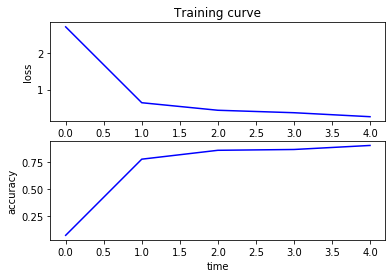

In [16]:
if __name__ == '__main__':
    main(train_data, train_labels)